In [33]:
import os
import ast
import json
import urllib
import urllib2
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pylab as plt
import pylab as pl
from cStringIO import StringIO
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [3]:
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
facilityQuery = "SELECT count(*), zipcodes FROM NYCAsthmasDismissals GROUP BY zipcodes"

In [5]:
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
facilities = pd.DataFrame.from_dict(facilityData['rows'])

In [6]:
facilities.head()

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


In [8]:
nyc_zip = gpd.read_file("ZIP_CODE_040114/ZIP_CODE_040114.shp")

In [9]:
nyc_zip['centers'] = nyc_zip['geometry'].centroid

In [10]:
facilities["zipcodes"] = facilities["zipcodes"].astype(unicode)

In [11]:
merged = pd.merge(left=facilities, right=nyc_zip, left_on="zipcodes", right_on="ZIPCODE")

In [12]:
merged = merged[["zipcodes", "count", "centers"]]

In [13]:
merged

,zipcodes,count,centers
0,10461,1699,POINT (1028292.72437689 247902.4282787614)
1,11373,405,POINT (1017941.215480481 208485.1046661779)
2,10451,1698,POINT (1005358.961284301 238316.0675161843)
3,11691,220,POINT (1050360.772370908 158235.4624321515)
4,11375,246,POINT (1026858.206454871 201880.2234817908)
5,10466,494,POINT (1026647.114925691 263909.2896452093)
6,11212,713,POINT (1008365.375095716 180768.9448568909)
7,11229,167,POINT (999714.2819237487 158289.3193893406)
8,11215,521,POINT (989857.1615907477 181769.9626017534)
9,11220,386,POINT (979603.6885367428 172876.8181350912)


In [14]:
krigdata = np.zeros((len(merged),3))

In [16]:
krigdata = np.array(zip(*[(pt[1].x, pt[1].y) for pt in enumerate(merged["centers"])])).T
krigdata = np.column_stack((krigdata, merged["count"]))

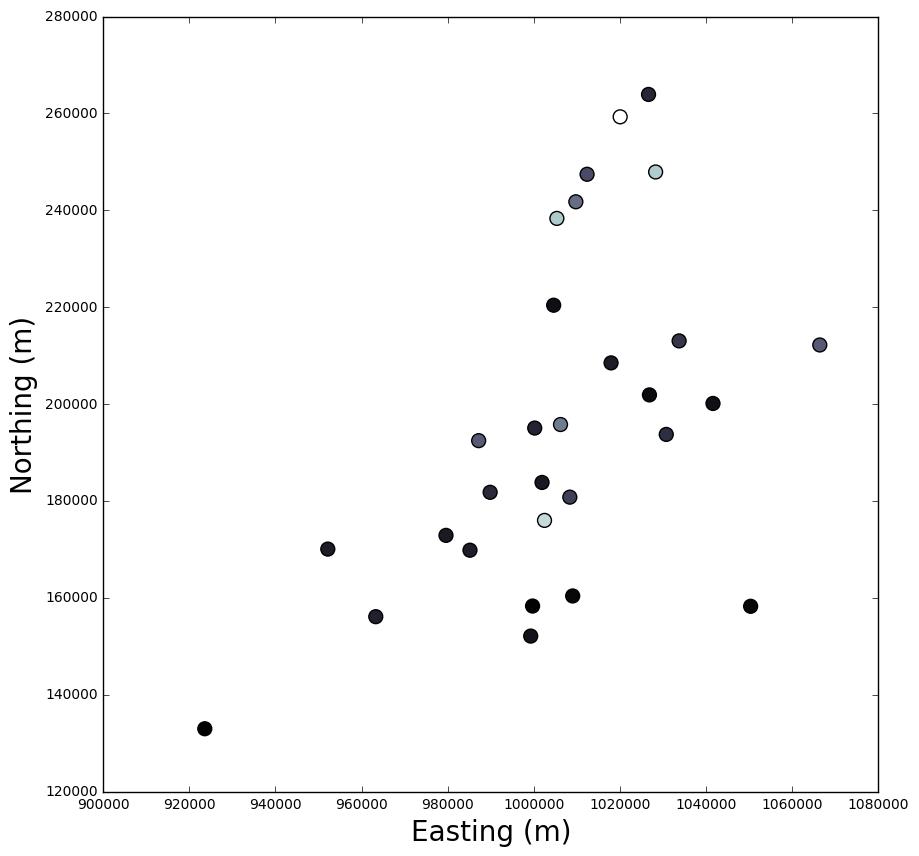

In [18]:
plt.figure(figsize=(10,10))
plt.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
plt.xlabel("Easting (m)", fontsize=20)
plt.ylabel("Northing (m)", fontsize=20)
plt.show()

In [25]:
from scipy.spatial.distance import pdist, squareform

In [26]:
def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )

def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T

In [54]:
lag = 100
mysv = SV( krigdata, np.arange(1, 10000, lag), 500 )

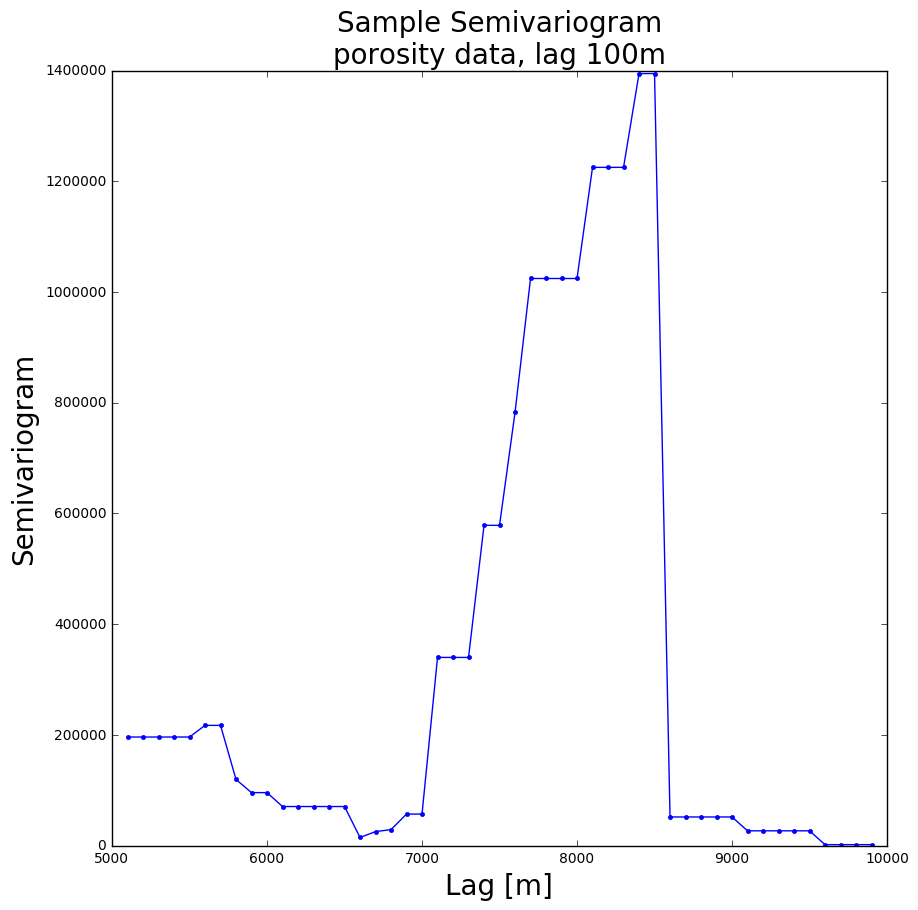

In [55]:
#hs = np.arange(0, 10500, 500)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram\nporosity data, lag %dm'%lag, fontsize=20)

In [51]:
def opt( fct, x, y, C0, meshSize=1000 ):
    parameterRange = [ x[1], x[-1] ]
    mse = np.zeros( meshSize )
    a = np.linspace( parameterRange[0], parameterRange[1], meshSize )
    for i in range( meshSize ):
        mse[i] = np.mean( ( y - fct( x, a[i], C0 ) )**2.0 )
    return a[ mse.argmin() ]        


def spherical( h, a, C0 ):
    #print "sph"

    '''
    Spherical model of the semivariogram
    '''
    # if h is a single digit

    
    if type(h) == np.float64:
        # calculate the spherical function
        if h <= a:
            return C0*( 1.5*h/a - 0.5*(h/a)**3.0 )
        else:
            return C0
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( spherical, h, a, C0 )

def exponentialngt(h, a, C0):
    #print "exp"
    '''
    Exponential model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-h/a)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( exponentialngt, h, a, C0 )

def gaussian(h, a, C0):
    #print "gaus"
    '''
    Gaussian model of the semivariogram
    '''
    # if h is a single digit
    if type(h) == np.float64:
        # calculate the spherical function
        return C0 - exp(-(h/a)**2)
    # if h is an iterable
    else:
        # calcualte the spherical function for all elements
        a = np.ones( h.size ) * a
        C0 = np.ones( h.size ) * C0
        return map( gaussian, h, a, C0 )

def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )



def cvmodel( P, model, hs, bw ):
    '''
    Input:  (P)      ndarray, data
            (model)  modeling function
                      - spherical
                      - exponentialngt
                      - gaussian
            (hs)     distances
            (bw)     bandwidth
    Output: (covfct) function modeling the covariance
    '''
    # calculate the semivariogram
    sv = SV( P, hs, bw )
    # calculate the sill
    C0 = C( P, hs[0], bw )
    #print C0
    # calculate the optimal parameters
    param = opt( model, sv[0], sv[1], C0 )
    # return a covariance function
    covfct = lambda h, a = param: C0 - model( h, a, C0 )
    return covfct

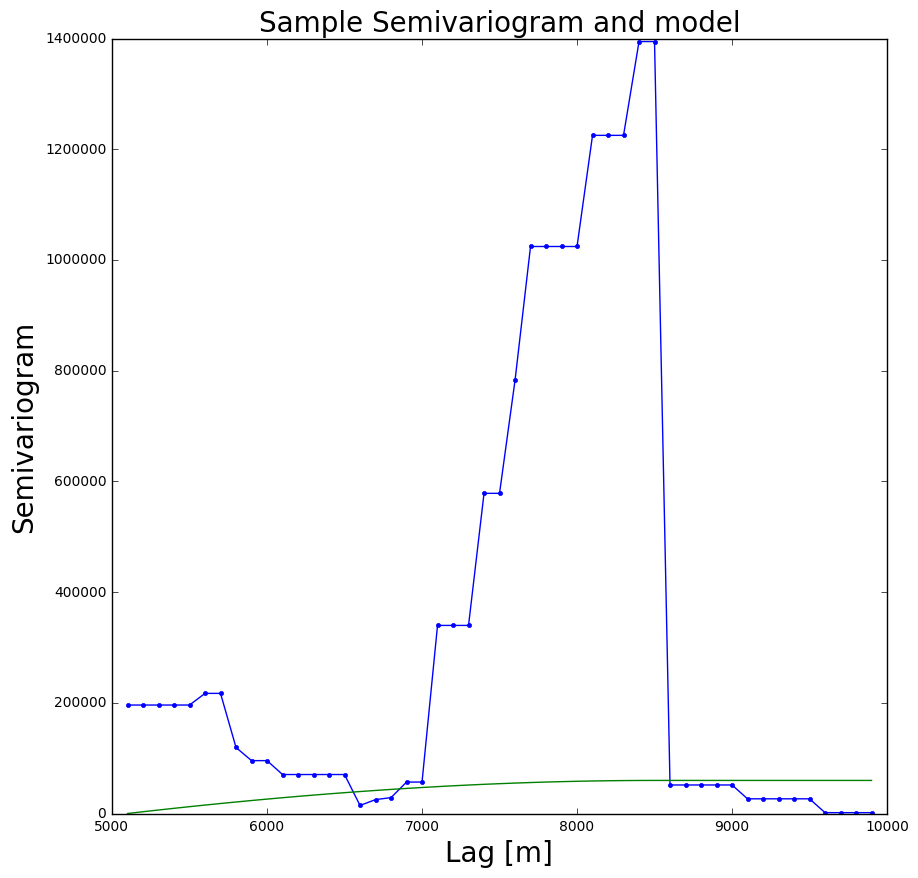

In [56]:
bw = 500
pl.figure(figsize=(10,10))
sp = cvmodel(krigdata , model=spherical, 
             hs=np.arange(0,10000,100), bw=bw)
#print sp(mysv[0])
sphere = sp(mysv[0])
plot( mysv[0], mysv[1], '.-' )
pl.plot(mysv[0], -sphere+sphere.max())
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram and model', fontsize=20) ;

In [57]:
def krige( P, model, hs, bw, u, N ):
    '''
    Input  (P)     ndarray, data
           (model) modeling function
                    - spherical
                    - exponential
                    - gaussian
           (hs)    kriging distances
           (bw)    kriging bandwidth
           (u)     unsampled point
           (N)     number of neighboring
                   points to consider
    '''
    # covariance function
    covfct = cvmodel( P, model, hs, bw )
    # mean of the variable
    mu = np.mean( P[:,2] )
 
    # distance between u and each data point in P
    d = np.sqrt( ( P[:,0]-u[0] )**2.0 + ( P[:,1]-u[1] )**2.0 )
    # add these distances to P
    P = np.vstack(( P.T, d )).T
    # sort P by these distances
    # take the first N of them
    P = P[d.argsort()[:N]]
 
    # apply the covariance model to the distances
    k = covfct( P[:,3] )
    # cast as a matrix
    k = np.matrix( k ).T
 
    # form a matrix of distances between existing data points
    K = squareform( pdist( P[:,:2] ) )
    # apply the covariance model to these distances
    K = covfct( K.ravel() )
    # re-cast as a NumPy array -- thanks M.L.
    K = np.array( K )
    # reshape into an array
    K = K.reshape(N,N)
    # cast as a matrix
    K = np.matrix( K )
 
    # calculate the kriging weights
    weights = np.linalg.inv( K ) * k
    weights = np.array( weights )
 
    # calculate the residuals
    residuals = P[:,2] - mu
 
    # calculate the estimation
    estimation = np.dot( weights.T, residuals ) + mu
 
    return float( estimation )

In [78]:
X0, X1 = krigdata[:,0].min(), krigdata[:,0].max()
Y0, Y1 = krigdata[:,1].min(), krigdata[:,1].max()
z = np.zeros((16,20))
dx, dy = (X1-X0)/z.shape[1], (Y1-Y0)/z.shape[0]
for i in range(z.shape[0]):
    print i,
    for j in range(z.shape[1]):
        z[i,j] = krige(krigdata, spherical, hs, bw, (dy*j,dx*i), 3 )


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15


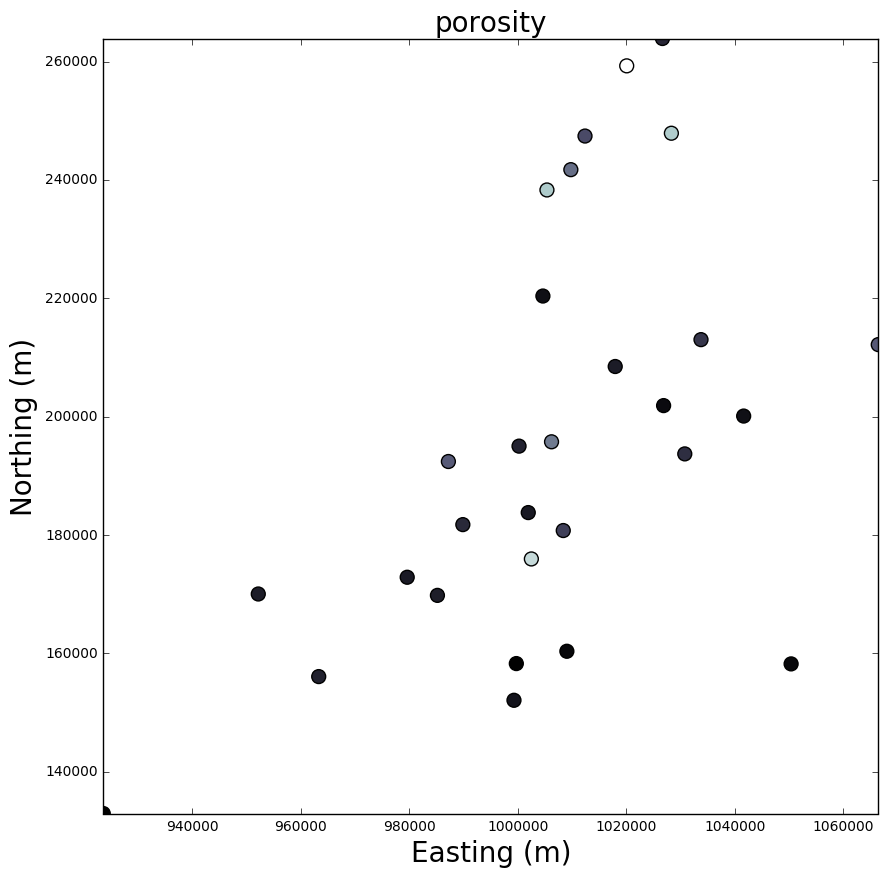

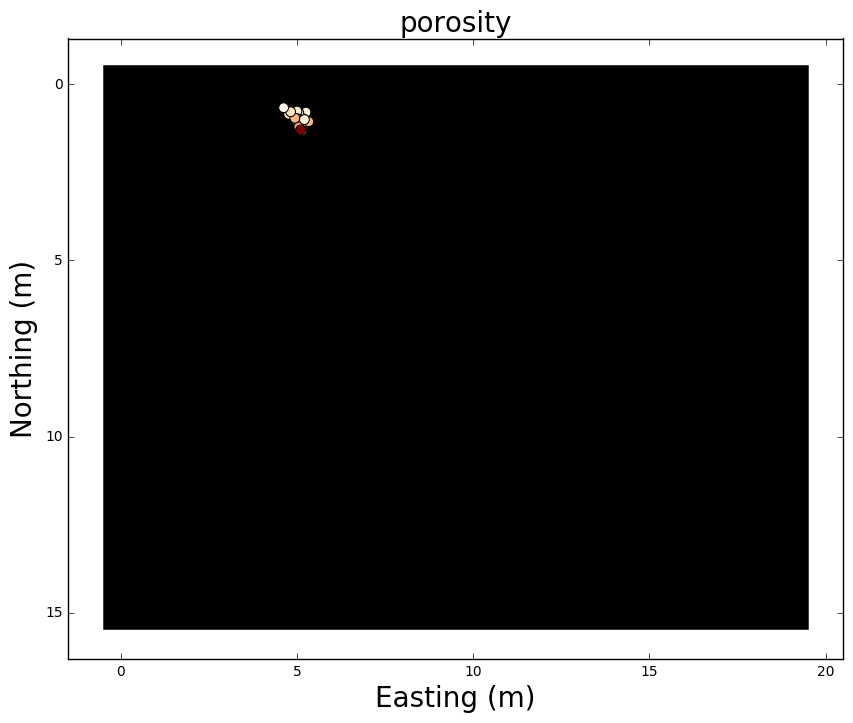

In [82]:
x = krigdata
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
ax.scatter(x[:,0], x[:,1], c=x[:,2], s=100, cmap='bone')
ax.set_ylim(Y0, Y1)
ax.set_xlim(X0, X1)
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
title = pl.title("porosity", fontsize=20)

ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
H = np.zeros_like(z)
for i in range( z.shape[0] ):
    for j in range( z.shape[1] ):
        H[i,j] = np.round( z[i,j]*300 )
ax.imshow( z, cmap='bone', interpolation='nearest' )
ax.scatter( x[:,0] / 200000.0, x[:,1] / 200000.0, c=x[:,2], cmap='OrRd', 
           linewidths=0.75, s=50 )

#xlim(0,99) ; ylim(0,89)
#ax.axis('off')
ax.set_xlabel("Easting (m)", fontsize=20)
ax.set_ylabel("Northing (m)", fontsize=20)
ax.set_title("porosity", fontsize=20)
#xticks( [2,5.0,7], [5000,10000,15000] )
#yticks( [2,5.0,7], [5000,10000,15000] )